Information on avg USA wind turbines: https://www.energy.gov/sites/prod/files/2019/08/f65/2018%20Wind%20Technologies%20Market%20Report%20FINAL.pdf

#### Things to consider:
- nameplate capacity of newly installed wind turbines in the US in 2018 was 2.43 MW (is this commercial)
- average rotor diameter is 115.6 meters
- average hub height in 2018 was 88.1 meters
- does power coefficient change with wind speed?
--------

#### The amount of energy generated by a wind turbine depends on:
- wind speed (main factor)
- the area swept by the blades
- air density
--------
#### Wind turbines require:
- a minimum wind speed (generally 12-14 km/h) to begin turning and generate electricity
- strong winds (50-60 km/h) to generate at full capacity
- winds of less than 90 km/h; beyond that speed, the turbines must be stopped to avoid damage
------


Resources for amount of land per turbine
- http://www.aweo.org/windarea.html
- https://sciencing.com/much-land-needed-wind-turbines-12304634.html
- https://www.nrel.gov/docs/fy09osti/45834.pdf

General resources:
- https://www.energy.gov/sites/prod/files/2015/03/f20/wv_chapter2_wind_power_in_the_united_states.pdf
- http://css.umich.edu/factsheets/wind-energy-factsheet
- https://www.raeng.org.uk/publications/other/23-wind-turbine

## Actual functions

#### Documentation:
- realiability module: https://reliability.readthedocs.io/en/latest/index.html
- basis for equation calculation : https://www.sciencedirect.com/science/article/pii/S0973082616308699
- kWh information/average values: 
    - https://www.windspire.ch/blog/2017/6/22/aep-part-1-capacity-and-more
    - https://www.windspire.ch/blog/2017/5/17/the-difference-between-kw-and-kwh-and-why-this-is-crucial-to-any-discussion-about-wind-energy


#### Notes:
variables and units: 
- rho (kg/m^3): air density
- A (m^2): area of the wind turbine blade
- v (m/s): wind speed
- Cp (unitless): capacity factor (efficiency)
- p(v) (unitless): Weibull distribution, include parameters k and c

#### Equations:
- power $P_{avail} = 0.5 \rho A v^{3} C_{p}$
- Weibull PDF $p(\nu)=\frac{k}{c}(\frac{\nu}{c})^{k-1}e^{-(\frac{\nu}{c})^{k}}$
- Average power $\sum_{0}^n C_p(\lambda) p(\nu) \nu^3 $
- AEO (Annual Energy Output) = $8760 * 0.5 \rho A *\sum_{0}^nC_p(\lambda) p(\nu) \nu^3 $

average power at each wind speed has been multiplied by the Weibull distribution for the given wind speed

## Example using data from New York City over all years available

In [1]:
import math

import h5pyd
import dateutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline # for power_eff
from pyproj import Proj
from reliability.Fitters import Fit_Weibull_2P #for weibull_coeff

In [2]:
import wind_energy

In [3]:
f = h5pyd.File("/nrel/wtk-us.h5", 'r')  

dset = f['windspeed_100m']

In [4]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
#dt.tail()

#### One year time slices for all the NYC wind data

In [5]:
twenty07 = dt.loc[(dt.datetime >= '2007-01-01') & (dt.datetime < '2008-01-01')].index
twenty08 = dt.loc[(dt.datetime >= '2008-01-01') & (dt.datetime < '2009-01-01')].index
twenty09 = dt.loc[(dt.datetime >= '2009-01-01') & (dt.datetime < '2010-01-01')].index
twenty10 = dt.loc[(dt.datetime >= '2010-01-01') & (dt.datetime < '2011-01-01')].index
twenty11 = dt.loc[(dt.datetime >= '2011-01-01') & (dt.datetime < '2012-01-01')].index
twenty12 = dt.loc[(dt.datetime >= '2012-01-01') & (dt.datetime < '2013-01-01')].index
twenty13 = dt.loc[(dt.datetime >= '2013-01-01') & (dt.datetime < '2014-01-01')].index

#print(twenty07, twenty08, twenty09, twenty10, twenty11, twenty12, twenty13)

In [6]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

In [7]:
NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

print("y,x indices for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

y,x indices for New York City: 		 (1044, 2375)
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 (40.709702, -73.992798)


Setting up the 2010 100m wind speed data

In [8]:
%time tseries_2010_NYC = dset[min(twenty10):max(twenty10)+1, NewYorkCity_idx[0], NewYorkCity_idx[1]]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 845 ms


Histogram of NYC wind data from 2010

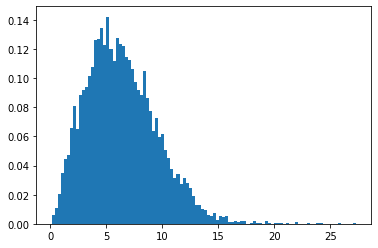

In [9]:
plt.hist(tseries_2010_NYC, bins = 100, density = True)

plt.show()

The wrapping function wind_energy_output, returns the annual energy output (aeo) in MegaWatt hours. Here is an example for the year 2010.

In [15]:
%time wind_energy.wind_energy_output(tseries_2010_NYC)

CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 181 ms


8128.537713583142

Here is an example of the aeo from all 7 years available in the wind data.

In [13]:
years = [twenty07, twenty08, twenty09, twenty10, twenty11, twenty12, twenty13]
%time
for i in years:
    tseries_tot_NYC = dset[min(i):max(i)+1, \
                             NewYorkCity_idx[0], NewYorkCity_idx[1]]
    print(wind_energy.wind_energy_output(tseries_tot_NYC))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs
7226.028551984976
6997.3827513718
7281.753506806564
8128.537713583142
6969.843104939896
6994.590721386248
7148.481260290716


### Rough drafts of the functions (doc strings in .py file)

#### Power Coefficient: $C_p$

In [ ]:
def power_eff(wind_sp):
    x = list(np.arange(3, 26.0, 1))
    y = [0.26, 0.35, 0.4, 0.41, 0.425, 0.445, 0.445, 0.425,0.38, 0.335, 0.28, 0.23, 0.19, 0.16, 
     0.13, 0.11, 0.09, 0.075, 0.065, 0.05, 0.04, 0.03, 0.02]
    
    cs = CubicSpline(x, y)
    
    Cp = float(cs(wind_sp))
    return Cp

In [ ]:
power_eff(12.3838592021)

Weibull coefficients (k, c)

In [ ]:
def weibull_coeff(tseries):
    data = list(tseries)
    wb = Fit_Weibull_2P(failures=data, show_probability_plot=False, print_results=False)
    k = wb.beta 
    c = wb.alpha
    
    return k, c

In [ ]:
weibull_coeff(tseries_NYC)

Weibull PDF $p(\nu)=\frac{k}{c}(\frac{\nu}{c})^{k-1}e^{-(\frac{\nu}{c})^{k}}$

In [ ]:
def weibull_pdf(wind_sp, k, c):
    
    pdf = (k/c)*(wind_sp/c)**(k-1)*math.exp(-(wind_sp/c)**k)
    
    return pdf

Summing Function

In [ ]:
def summation(tseries):
    summ_list = []
    k, c = weibull_coeff(tseries)
    
    for wind_sp in np.arange(tseries.min(), tseries.max(), 1.0):
        Cp = power_eff(wind_sp)
        pdf = weibull_pdf(wind_sp, k, c)
        
        tot_sp = Cp * wind_sp**3
        max_sp = 378 # max wind speed (for max power of turbine) for the rho and A from turbine specs is 378
                     # 2430 kW = 0.5 * rho * A * Cp * v^3
        
        # wind must be between 3.5 and 25 m/s for turbine operation
        if wind_sp <3.5 or wind_sp >25.0:
            pass
        # for the turbine specs max power 2430 kW. 
        # This bit of code makes sure not to account for power over the limit.
        else:
            if tot_sp <= max_sp:
                summ = tot_sp * pdf
            else:
                summ = 378 * pdf
                
            summ_list.append(summ)
    
    tot_sum = sum(summ_list)
    
    return tot_sum

In [ ]:
summation(tseries_NYC)

AEO (Annual Energy Output) = $8760 * 0.5 \rho A *\sum_{0}^n C_p(\lambda) p(\nu) \nu^3 $

In [ ]:
def wind_energy_output(tseries):
    summ = summation(tseries)
    
    rho = 1.225
    area = math.pi*(115.6/2)**2
    hours_year = 365*24 #hours in a year
    
    # divide by 1e6 to make output in MWh
    aeo_mwh = (hours_year * 0.5 * rho * area * summ)/1e6
    
    return aeo_mwh

In [ ]:
%time wind_energy_output(tseries_NYC)

In [ ]:
years = [twenty07, twenty08, twenty09, twenty10, twenty11, twenty12, twenty13]
for i in years:
    tseries_NYC = dset[min(i):max(i)+1, \
                             NewYorkCity_idx[0], NewYorkCity_idx[1]]
    print(wind_energy_output(tseries_NYC))

-------

In [ ]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [ ]:
cs = CubicSpline(x, y)
xs = np.arange(3, 25.0, 0.1)

plt.figure(figsize=(8,5))
plt.plot(x,y, 'o')
plt.plot(xs, cs(xs))
(cs((6.62)))

In [ ]:
import reliability

In [ ]:
from reliability.Fitters import Fit_Weibull_2P
import matplotlib.pyplot as plt
data = [42.1605147, 51.0479599, 41.424553, 35.0159047, 87.3087644, 30.7435371, 52.2003467, 35.9354271, 71.8373629, 59.171129]
wb = Fit_Weibull_2P(failures=data, show_probability_plot = True)
print(wb.alpha)
print(wb.beta)
plt.show()